# Import python packages

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.layers import LSTM
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.utils import to_categorical
import pandas as pd

SEED = 7
np.random.seed(SEED)

2025-07-30 09:07:22.889878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753866442.915359 3188410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753866442.923604 3188410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753866442.947640 3188410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753866442.947660 3188410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753866442.947662 3188410 computation_placer.cc:177] computation placer alr

# Define parameters and load dataset

In [2]:
MODEL_NAME = "CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32"

# if experiment is not None:
#     experiment.set_name(MODEL_NAME)
#     experiment.set_filename(MODEL_NAME +'.ipynb')

# Word2Vec_MODEL_NAME = "Word2Vec_No_Indexed_3_iters_5_negative_1_window"  #################
Word2Vec_MODEL_NAME = "test"


TEST_SIZE = 0.2
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
num_classes = len(class_names)
DATA_PATH = './'
MODELS_PATH = './Models/'
RESULTS_PATH = '../../Results/'

DATA = "caida_s1_tor"
dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(dataset.shape, labels.shape)

(861840, 2) (861840,)


In [3]:
from oix_utils import load_routes

bgp_routes = load_routes("./Previous Methods/big_conf_paths.csv")

Filter TOR to only the ASes we see in the routes

In [4]:
def unique_asn(bgp_routes: np.ndarray) -> set[str]:
    asns = set()
    for as_path in bgp_routes:
        for AS in as_path:
            asns.add(AS)
    return asns

def filter_tor(tor_dataset: np.ndarray, tor_labels: np.ndarray, bgp_routes: set):

    topology_ASes = unique_asn(bgp_routes)
    
    filtered_tor_dataset = []
    filtered_tor_labels = []

    for i in range(tor_dataset.shape[0]):
        as1, as2 = tor_dataset[i, :]
        if as1 not in topology_ASes:
            continue
        if as2 not in topology_ASes:
            continue

        filtered_tor_dataset.append([as1, as2])
        filtered_tor_labels.append(tor_labels[i])

    return np.asarray(filtered_tor_dataset), np.asarray(filtered_tor_labels)

dataset, labels = filter_tor(dataset, labels, bgp_routes)

In [5]:
for i, label in enumerate(labels):
    if label == 3:
        labels[i] = 2
pd.Series(labels).value_counts()

0    609450
2    120162
1    120162
dtype: int64

In [6]:
print(dataset[0])

['1' '11537']


In [7]:
ASN_set = set()
for tor in dataset:
    ASN_set.add(tor[0])
    ASN_set.add(tor[1])

print(len(ASN_set))

60004


In [8]:
from collections import Counter
c_caida = Counter(labels)
print(c_caida)

Counter({0: 609450, 2: 120162, 1: 120162})


# Load Word2Vec embedding

In [9]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load(MODELS_PATH + Word2Vec_MODEL_NAME + ".word2vec")
emdeddings = word2vec_model.wv.vectors
total_ASNs, embedding_vecor_length = emdeddings.shape
print(total_ASNs, embedding_vecor_length)

60124 32


## Generate indexed data with fixed length

In [10]:
# map ASN (the “word”) → its row‑index in the embedding matrix
def asn2idx(asn):
    return word2vec_model.wv.key_to_index[asn]

# map row‑index → the corresponding ASN
def idx2asn(idx):
    return word2vec_model.wv.index_to_key[idx]

def dataset_asn2idx(dataset):
    dataset_idx = np.zeros([len(dataset), 2], dtype=np.int32)

    for i, pair in enumerate(dataset):
            dataset_idx[i, 0] = asn2idx(pair[0])
            dataset_idx[i, 1] = asn2idx(pair[1])
    return dataset_idx

def dataset_idx2asn(dataset_idx):
    dataset_asn = np.zeros([len(dataset_idx), 2], dtype = np.dtype('U6'))

    for i, pair in enumerate(dataset_idx):
            dataset_asn[i, 0] = idx2asn(pair[0])
            dataset_asn[i, 1] = idx2asn(pair[1])
    return dataset_asn
        
dataset = dataset_asn2idx(dataset)

# Generate training and test sets

## Shuffle dataset

In [11]:
from sklearn.utils import shuffle
indices = np.arange(len(dataset))
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]
# dataset, labels = shuffle(dataset, labels, random_state=7)

## Train-Test split

In [12]:
indices = np.arange(len(dataset))
x_training, x_test, indices_training, indices_test = train_test_split(dataset, indices, test_size=TEST_SIZE)
y_training = labels[indices_training]
y_test = labels[indices_test]

del dataset, labels

In [13]:
print(x_training.shape, y_training.shape)
print(x_test.shape, y_test.shape)

print(1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print(training_c, test_c)

(679819, 2) (679819,)
(169955, 2) (169955,)
0.7999997646433051
Counter({0: 487616, 2: 96185, 1: 96018}) Counter({0: 121834, 1: 24144, 2: 23977})


# Define and run NN model
## Define model

In [14]:
embedding_trainable = False
experiment=None
if experiment is not None:
    experiment.log_parameter("embedding_trainable", embedding_trainable)
input_length = 2

model = Sequential()
model.add(Embedding(total_ASNs, embedding_vecor_length, input_shape=(2,),
                    weights=[emdeddings], trainable=embedding_trainable))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2], model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2], model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/home/justin/projects/path4bgp/BGP2Vec/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-30 09:07:54.201911: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2, 32)          │     1,923,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953,299 (7.45 MB)

 Trainable params: 29,331 (114.57 KB)

 Non-trainable params: 1,923,968 (7.34 MB)

None


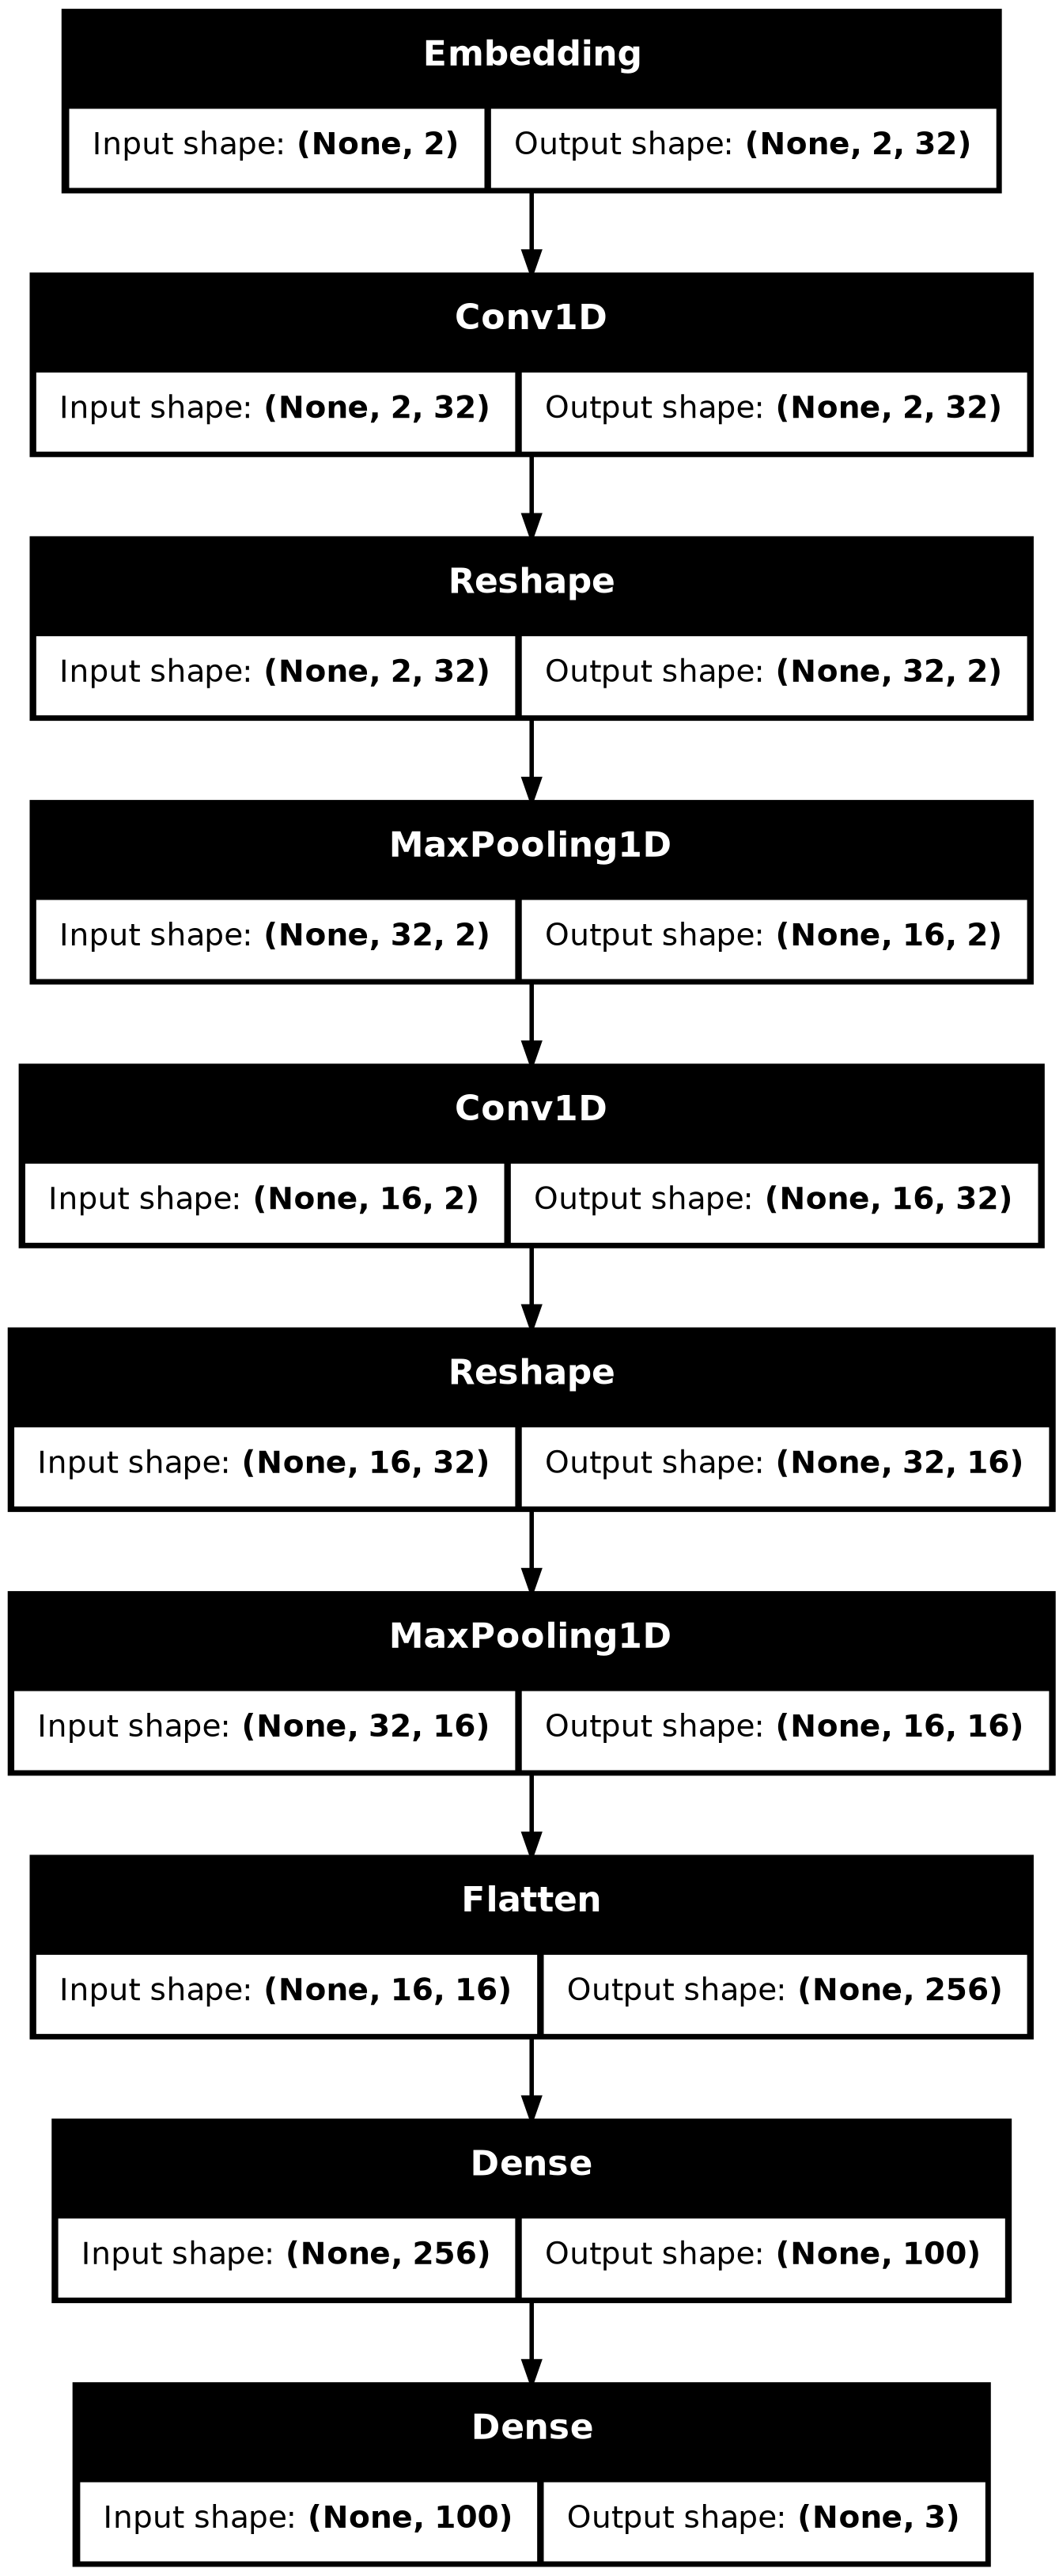

In [15]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file="./Results/" + MODEL_NAME + "_" + 'model.png')

## convert class vectors to binary class matrices

In [16]:
y_training_vector = to_categorical(y_training, num_classes)
y_test_vector = to_categorical(y_test, num_classes)

## Use class_weight to deal with unbalanced dataset

In [17]:
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', list(range(num_classes)), y_training)
# print(class_weights)
class_weights = None

## Fit model

In [18]:
# checkpointer_loss = ModelCheckpoint(filepath= MODELS_PATH + MODEL_NAME + '_loss.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= MODELS_PATH + MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

# callbacks = [checkpointer_loss,checkpointer_acc] #tensorboard

from keras.callbacks import ModelCheckpoint

# 1) checkpoint on loss (defaults to 'val_loss')
checkpointer_loss = ModelCheckpoint(
    filepath=MODELS_PATH + MODEL_NAME + "_loss.weights.h5",
    monitor="val_loss",  # this is the default so you could even omit it
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

# 2) checkpoint on accuracy
checkpointer_acc = ModelCheckpoint(
    filepath=MODELS_PATH + MODEL_NAME + "_acc.weights.h5",
    monitor="val_accuracy",  # new name for validation accuracy
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

callbacks = [checkpointer_loss, checkpointer_acc]


In [19]:
import math

epochs = 40 #################################   3  ##########
if experiment is not None:
    experiment.log_parameter("epochs", epochs)

batch_size = 64
if experiment is not None:
    experiment.log_parameter("batch_size", batch_size)

steps_per_epoch = math.ceil(len(x_training)/batch_size)
if experiment is not None:
    experiment.log_parameter("steps_per_epoch", steps_per_epoch)

val_batch_size = 1024
if experiment is not None:
    experiment.log_parameter("val_batch_size", val_batch_size)

validation_steps = math.ceil(len(x_test)/val_batch_size)
if experiment is not None:
    experiment.log_parameter("validation_steps", validation_steps)

def val_generator(features, labels, val_batch_size):
    index = 0
    while True:
        index += val_batch_size
        batch_features, batch_labels = features[index-val_batch_size:index], labels[index-val_batch_size:index]
        if index >= len(features):
            index = 0
        yield batch_features, batch_labels
        
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]

In [21]:
experiment = None
if experiment is not None:
    with experiment.train():
        history = model.fit(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
                        epochs=epochs, callbacks=callbacks, class_weight=class_weights,
                        validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
                        validation_steps=validation_steps)
else:
    history = model.fit(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
                        epochs=epochs, callbacks=callbacks, class_weight=class_weights,
                        validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
                        validation_steps=validation_steps)
    

Epoch 1/40
10618/10623 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8785 - loss: 0.3262
Epoch 1: val_loss improved from inf to 0.21139, saving model to ./Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.92539, saving model to ./Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.weights.h5
10623/10623 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8785 - loss: 0.3262 - val_accuracy: 0.9254 - val_loss: 0.2114
Epoch 2/40
10617/10623 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9282 - loss: 0.2035
Epoch 2: val_loss improved from 0.21139 to 0.18950, saving model to ./Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.weights.h5

Epoch 2: val_accuracy improved from 0.92539 to 0.93455, saving model to ./Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.weights.h5
10623/10623 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9282 - loss: 0.2035 - val_accuracy: 0.9345 - val_

# Plot history accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


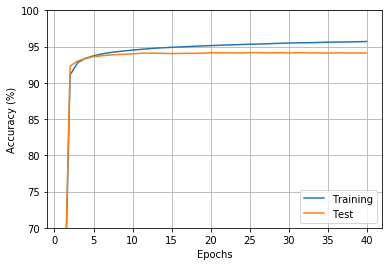

In [ ]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


with open(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)
    if experiment is not None:
        experiment.log_asset(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl")
    
# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, smooth([y*100 for y in history.history['acc']],2))
# plt.plot(x, [y*100 for y in history_history['val_acc']])
plt.plot(x, smooth([y*100 for y in history.history['val_acc']],2))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim(70,100) ###########################
plt.legend(['Training', 'Test'], loc='lower right')
plt.grid()
plt.savefig(RESULTS_PATH + MODEL_NAME +  " accuracy history", bbox_inches='tight')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + " accuracy history.png")
plt.show()

# Final evaluation of the model
## Evaluate accuracy over the test set

In [ ]:
model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')

In [ ]:
test_scores = model.evaluate(x_test, y_test_vector, batch_size=val_batch_size, verbose=1)
    
    
print("Accuracy: %.2f%%" % (test_scores[1]*100))

116153/116153 [==============================] - 2s 15us/step
Accuracy: 94.19%


In [ ]:
y_test_prediction = model.predict_classes(x_test, batch_size=val_batch_size, verbose=1)

116153/116153 [==============================] - 1s 6us/step


In [ ]:
y_training_prediction = model.predict_classes(x_training, batch_size=val_batch_size, verbose=1)

464609/464609 [==============================] - 5s 11us/step


## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [ ]:
p2c = 2
c2p = 1

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])

p2c_training_label_vector = to_categorical([p2c]*len(p2c_training), num_classes)
p2c_training_oposite_label_vector = to_categorical([c2p]*len(p2c_training_oposite), num_classes)

print(p2c_training.shape, p2c_training_oposite.shape, p2c_training_oposite_label_vector.shape)

(65736, 2) (65736, 2) (65736, 3)


In [ ]:
p2c_training_scores = model.evaluate(p2c_training, p2c_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_scores[1]*100))

p2c_training_oposite_scores = model.evaluate(p2c_training_oposite, p2c_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores[1]*100))

65736/65736 [==============================] - 2s 30us/step
Accuracy: 99.08%
65736/65736 [==============================] - 2s 29us/step
Accuracy: 95.81%


## Test if by learning (asn1, asn2) -> p2p then (asn2, asn1) -> p2p and vice versa

In [ ]:
p2p = 0

p2p_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2p])
p2p_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2p_training])

p2p_training_label_vector = to_categorical([p2p]*len(p2p_training), num_classes)
p2p_training_oposite_label_vector = to_categorical([p2p]*len(p2p_training_oposite), num_classes)

In [ ]:
p2p_training_scores = model.evaluate(p2p_training, p2p_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_scores[1]*100))

p2p_training_oposite_scores = model.evaluate(p2p_training_oposite, p2p_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_oposite_scores[1]*100))

14229/14229 [==============================] - 0s 29us/step
Accuracy: 92.09%
14229/14229 [==============================] - 0s 28us/step
Accuracy: 87.49%


## Plot and save a confusion matrix for results over the test set

### Define a function

In [ ]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow([[100*j for j in i] for i in cm], interpolation='nearest', cmap=cmap)
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


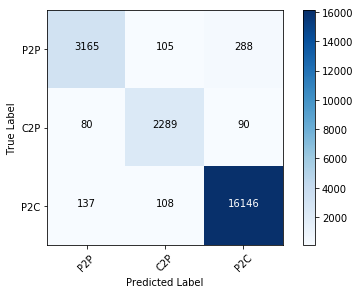

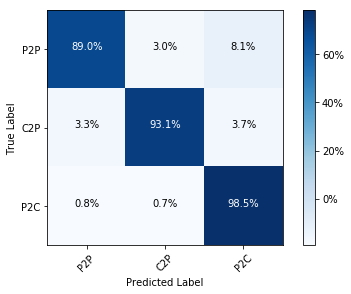

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization.png', 
                         name='Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'Normalized_confusion_matrix')

if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'Normalized_confusion_matrix.png',
                         name='Normalized_confusion_matrix.png')

plt.show()

## Plot cm for training set

Confusion matrix, without normalization
Normalized confusion matrix


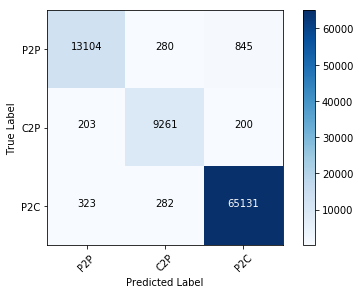

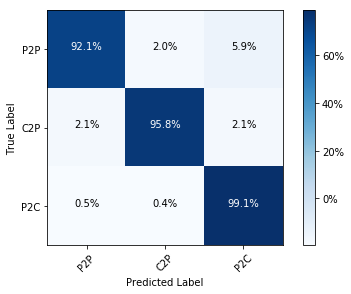

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_training, y_training_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'training_Normalized_confusion_matrix')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'training_Normalized_confusion_matrix.png')

plt.show()

# Export the model to a file

In [ ]:
model_json = model.to_json()
with open(MODELS_PATH + MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODELS_PATH + MODEL_NAME + '.h5')
print("Save Model")

Save Model


# Export results to a csv file (with original ASNs)
## Define functions

In [ ]:
def dataset_idx2asn(dataset, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)

    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels(dataset, labels, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn


def dataset_idx2asn_labels_predictions(dataset, labels, predictions, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels_predictions_prob(dataset, labels, predictions, prob, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
        prob = np.take(prob, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        for p in prob[i]:
            route_asn.append(round(p,4))
        
        dataset_asn.append(route_asn) 
    return dataset_asn

import csv
def export_csv(dataset, csv_name, header_type='with_gt'):
    header_types = {
        'reg': ["AS1", "AS2", "Label", "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"],
        'with_gt': ["AS1", "AS2", "Label", 'GT', "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"]
    }
    
    with open(csv_name + '.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        if header_type is not None:
            csv_writer.writerow(header_types[header_type])
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [ ]:
y_test_prob = model.predict_proba(x_test, batch_size=val_batch_size, verbose=1)
# y_training_prob = model.predict_proba(x_training, batch_size=val_batch_size, verbose=1)

116153/116153 [==============================] - 1s 7us/step


In [ ]:
# # Create test misclassified dataset
x_test_misclassified = np.asarray([route for i,route in enumerate(x_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prediction = np.asarray([label for i,label in enumerate(y_test_prediction) if y_test[i] != y_test_prediction[i]])
y_test_misclassified = np.asarray([label for i,label in enumerate(y_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prob = np.asarray([prob for i,prob in enumerate(y_test_prob) if y_test[i] != y_test_prediction[i]])

print(len(x_test_misclassified), len(y_test_misclassified_prediction), len(y_test_misclassified))
print(y_test_misclassified_prob.shape)

6753 6753 6753 6753
(6753, 3)


In [ ]:
dataset_test_misclassified = dataset_idx2asn_labels_predictions_prob(x_test_misclassified, y_test_misclassified,
                                        y_test_misclassified_prediction, y_test_misclassified_prob)
export_csv(dataset_test_misclassified, RESULTS_PATH + MODEL_NAME + "_test_misclassified")

In [ ]:
y_test_misclassified_prob_max = np.array([y_test_misclassified_prob[i][pred] for i, pred in enumerate(y_test_misclassified_prediction)])
print(y_test_misclassified_prob_max[:10])

[0.96811545 0.56680095 0.8645542  0.9803387  0.7388056  0.9407794
 0.9536408  0.9981211  0.9132586  0.5935503 ]


In [ ]:
indexes = np.array(list(range(len(x_test_misclassified))))
indexes = [x for _, x in sorted(zip(y_test_misclassified_prob_max,indexes), reverse=True)]
print(indexes[:100])
print(y_test_misclassified_prob_max[indexes[0]])

[4085, 3980, 678, 1566, 6738, 5789, 2122, 72, 679, 1927, 1261, 1043, 5839, 30, 2664, 4697, 4711, 3824, 561, 1362, 3325, 5737, 5792, 2048, 2549, 5591, 323, 2706, 3973, 2506, 4700, 2961, 5761, 6244, 5950, 947, 4891, 4096, 1737, 3749, 6101, 4034, 700, 1148, 5064, 2071, 2585, 6191, 5199, 2559, 5444, 1973, 1135, 5710, 3573, 3462, 3127, 5061, 1801, 1145, 424, 5363, 2954, 5132, 2708, 2187, 2422, 3601, 6265, 1307, 4008, 456, 1946, 3773, 5095, 2243, 2483, 1680, 6060, 6435, 3247, 3258, 3892, 6653, 673, 404, 5873, 3531, 2785, 5949, 711, 1414, 3602, 2305, 1110, 6392, 6143, 2118, 2864, 3431]
0.999998


## Export Results

In [ ]:
dataset_misclassified = dataset_idx2asn_and_labels(x_test_misclassified, y_test_misclassified_prediction)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")